In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix, AE1SensitivityMatrix
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator, signal_time_to_freq_domain
from tools.likelihood import get_dh, get_hh

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [2]:
Tobs = YRSID_SI
dt = 5.
include_T_channel = True

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

# TODO: Make it work for multiple MBHBs in the signal
f_ref = 0.0
phi_ref = 0.0
m1 = 1e6
m2 = 5e5
a1 = 0.2
a2 = 0.4
dist = 10e3 * PC_SI * 1e6  # 3e3 in Mpc
inc = np.pi/3
beta = np.pi/4.
lam = np.pi/5.
psi = np.pi/6.
t_ref = 0.5 * YRSID_SI  # in the SSB reference frame

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(direct=False, fill=True, squeeze=False, length=1024)

signal_with_noise_t = sim(seed = 42, parameters=parameters, modes=modes, waveform_kwargs=waveform_kwargs)

3 (3, 6311628) (1, 3, 6311628)


In [39]:
zxx[0]

array([[ 5.65728417e-22+0.00000000e+00j,  1.15815736e-21+0.00000000e+00j,
         1.39117457e-21+0.00000000e+00j, ...,
         4.83655594e-22+0.00000000e+00j,  6.70533629e-22+0.00000000e+00j,
         1.09336769e-22+0.00000000e+00j],
       [-2.67584218e-22+3.63224953e-22j, -5.81729468e-22-5.72611239e-23j,
        -7.24215530e-22+1.14022930e-22j, ...,
        -2.26482213e-22+8.22011897e-23j, -3.66334913e-22-9.27926900e-24j,
         2.42518565e-23-1.00918071e-22j],
       [-7.01121029e-24-2.19739203e-22j,  7.85035356e-24+7.61660754e-23j,
         2.77623152e-23-3.61274339e-23j, ...,
        -2.17626459e-23-1.58821147e-23j, -2.98887178e-23-3.68368684e-23j,
        -8.06644873e-23-3.77056761e-23j],
       ...,
       [ 6.95214476e-23-4.29198485e-23j,  1.64905551e-22-9.38689892e-23j,
         1.04654203e-22-2.99904773e-22j, ...,
        -5.07234659e-22-1.21098100e-22j,  1.59393406e-22-1.02785382e-22j,
         1.12922605e-22+2.86364343e-23j],
       [ 1.85332336e-24+1.69779261e-23j, -1.

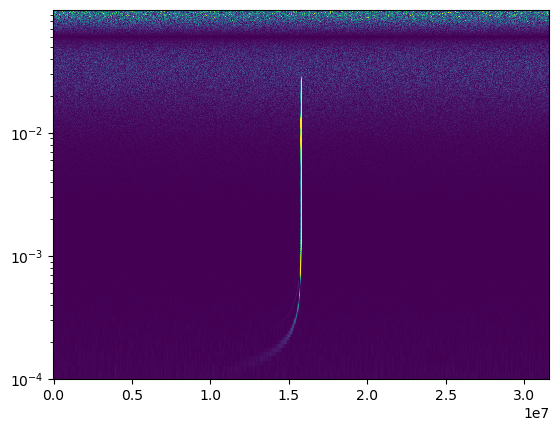

In [40]:
f, t, Zxx = sp.signal.stft(sim.signal_with_noise_t[0][0], fs=1/dt, nperseg=15000)
max_freq = 0.1
min_freq = 1e-4
max_freq_idx = np.searchsorted(f, max_freq)
min_freq_idx = np.searchsorted(f, min_freq)

plt.figure()
plt.pcolormesh(t, f[min_freq_idx:max_freq_idx], np.abs(Zxx[min_freq_idx:max_freq_idx]), vmin=0, 
            vmax= np.max(np.abs(Zxx[min_freq_idx:max_freq_idx]))/10)
plt.yscale('log')

In [3]:
snr_from_lisatools = sim.SNR_optimal_lisatools()
snr_my_code = sim.SNR_optimal()
print(snr_from_lisatools, snr_my_code)

[3530.17281808] [3530.17281808]


In [4]:
data = sim.signal_with_noise_f
f_array = np.fft.rfftfreq(sim.signal_with_noise_t.shape[2])  # returns the correct frequency array for the signal with noise
f_array[0] = f_array[1]  # avoid zero frequency
data[0]

array([[ 2.87997753e-15+0.00000000e+00j, -8.01664455e-16-9.14272412e-15j,
         1.87766792e-15+4.67276244e-15j, ...,
        -5.23505584e-17+5.48756912e-17j,  1.68362572e-17+4.01699770e-17j,
        -6.00596015e-17+0.00000000e+00j],
       [ 7.58040788e-15+0.00000000e+00j,  1.06930310e-15+2.58035370e-15j,
        -5.80231866e-15+8.54461968e-16j, ...,
         2.63527057e-17+7.97395671e-17j, -4.20193941e-17+8.92831265e-17j,
         4.73211831e-17+0.00000000e+00j],
       [ 4.85692261e-26+0.00000000e+00j, -6.34395476e-26+3.34432672e-25j,
         4.97588387e-25+3.26697624e-25j, ...,
         9.36424551e-17-3.08722057e-17j,  1.36859091e-17-2.33649339e-17j,
         2.51283726e-17+0.00000000e+00j]], shape=(3, 3155815))

In [5]:
#sim.df, len(sim.signal_with_noise_t[0,0])*sim.dt, sim.Tobs, sim.Tobs / sim.dt, sim.time.shape, sim.freq

In [6]:
template = wave_gen(*parameters, freqs=f_array, modes=modes, **waveform_kwargs)[0]
if include_T_channel==False:
    template = template[:2]  # remove T channel if not included

In [7]:
dh = get_dh(data, template, sens_mat=sim.sens_mat, df=f_array[2] - f_array[1])

In [8]:
hh = get_hh(template, sens_mat=sim.sens_mat, df=f_array[2] - f_array[1])

In [9]:

#template = DataResidualArray(template, f_arr=f_array)
#data = DataResidualArray(data[0], f_arr=f_array)
#analysis = AnalysisContainer(data_res_arr=data, sens_mat=sim.sens_mat)
#print("optimal snr:", np.sqrt(hh), "detected snr:", dh/(np.sqrt(hh)))

In [16]:
signal_with_noise_t

array([[[-2.80159126e-20,  1.53655896e-20, -2.79104516e-20, ...,
          1.76143467e-20,  1.82861748e-21,  8.67791510e-21],
        [-2.70074302e-21,  2.15638172e-20, -6.20267318e-21, ...,
          1.52317117e-20, -1.45921959e-20, -5.09514868e-22],
        [ 3.49687222e-20, -4.10148011e-20,  2.85844086e-20, ...,
         -5.08069924e-21,  1.18888019e-20, -1.97811437e-20]]],
      shape=(1, 3, 6311628))

In [20]:
np.fft.irfft(data, axis=-1)

array([[[-2.80159126e-20,  1.53655896e-20, -2.79104516e-20, ...,
          1.76143467e-20,  1.82861748e-21,  8.67791510e-21],
        [-2.70074302e-21,  2.15638172e-20, -6.20267318e-21, ...,
          1.52317117e-20, -1.45921959e-20, -5.09514868e-22],
        [ 3.49687222e-20, -4.10148011e-20,  2.85844086e-20, ...,
         -5.08069924e-21,  1.18888019e-20, -1.97811437e-20]]],
      shape=(1, 3, 6311628))

In [23]:
sim.df*50000

np.float64(0.001584377279522811)

In [ ]:
nperseg = 50000  # Or another value tuned to your data
signal_1_t = signal_with_noise_t
signal_2_t = np.fft.irfft(data, axis=-1)

f_1, t_1, Z_1 = sp.signal.stft(signal_1_t, fs=sim.df, nperseg=nperseg)
f_2, t_2, Z_2 = sp.signal.stft(signal_2_t, fs=sim.df, nperseg=nperseg)

df_new = f_1[1] - f_1[0]

In [1]:
Z_1.shape

NameError: name 'Z_1' is not defined

In [ ]:
h_h = self.stft_inner_product(Z_temp, Z_temp, psd=self.sens_mat, f=f_data, **kwargs_in)

y_A = np.divide((A_tf[0].conj() * B_tf[0]) , np.array(AET1SensitivityMatrix(f)[0].T)[:, np.newaxis])
y_E = np.divide((A_tf[1].conj() * B_tf[1]) , np.array(AET1SensitivityMatrix(f)[1].T)[:, np.newaxis])

df = f[1] - f[0]
# df is sunk into trapz
tmp_out = 4 * (y_A + y_E) * df


In [ ]:
def stft_inner_product( A_tf, B_tf, psd, f, **kwargs):
        # loop the inner product over the time segments
        ip = 0
        #print(A_tf.shape[0], A_tf.shape)
        y_A = np.divide((A_tf[0].conj() * B_tf[0]) , np.array(AET1SensitivityMatrix(f)[0].T)[:, np.newaxis])
        y_E = np.divide((A_tf[1].conj() * B_tf[1]) , np.array(AET1SensitivityMatrix(f)[1].T)[:, np.newaxis])
        
        df = f[1] - f[0]
        # df is sunk into trapz
        tmp_out = 4 * (y_A + y_E) * df


        return np.sum(tmp_out)

def template_likelihood_tf(
    self,
    template: DataResidualArray,
    include_psd_info: bool = False,
    phase_maximize: bool = False,
    fs: float = 1.0,
    **kwargs: dict,
) -> float:
    """Calculate the Likelihood of a template against the data.

    Args:
        template: Template signal.
        include_psd_info: If ``True``, add the PSD term to the Likelihood value.
        phase_maximize: If ``True``, maximize over an overall phase.
        fs: Sampling frequency for the STFT.
        **kwargs: Keyword arguments to pass to :func:`lisatools.diagnostic.inner_product`.

    Returns:
        Likelihood value.

    """

    kwargs_in = kwargs.copy()
    if "psd" in kwargs_in:
        kwargs_in.pop("psd")

    if "complex" in kwargs_in:
        kwargs_in.pop("complex")

    nperseg = 50000  # Or another value tuned to your data
    wave_time_domain = np.fft.irfft(self.data_res_arr.data_res_arr, axis=-1)
    temp_time_domain = np.fft.irfft(template.data_res_arr, axis=-1)

    f_data, t_data, Z_data = sp.signal.stft(wave_time_domain, fs=fs, nperseg=nperseg*fs)
    f_temp, t_temp, Z_temp = sp.signal.stft(temp_time_domain, fs=fs, nperseg=nperseg*fs)

    d_d = self.stft_inner_product(Z_data, Z_data, psd=self.sens_mat, f=f_data, **kwargs_in)
    
    h_h = self.stft_inner_product(Z_temp, Z_temp, psd=self.sens_mat, f=f_data, **kwargs_in)

    non_marg_d_h=self.stft_inner_product(Z_data, Z_temp, psd=self.sens_mat, complex=True, f=f_data, **kwargs_in)
    d_h = np.abs(non_marg_d_h) if phase_maximize else non_marg_d_h.copy()
    
    like_out = -1 / 2 * (d_d + h_h - 2 * d_h).real
    
    #print(f"d_d: {d_d}, h_h: {h_h}, d_h: {d_h}")

    # TO DO: if include_psd_info
    #         
    return like_out
    